### checking the correctness of the GT affine matrices

In [ ]:
from real_motion_simulations.prepare_experiment_svr import SingleVolSVR
from torch.utils.data import DataLoader
from utils import *


In [42]:
experiment_path  = '/tcmldrive/NogaK/noga_experiment_data/'
# get_motion_params(experiment_path)
ds = SingleVolSVR(experiment_path=experiment_path)
dl = DataLoader(ds, batch_size=1, shuffle=False)
for i_batch, sample_batched in enumerate(dl):
    dwi_stacks , motion_mask_data, T1_image, stacks_indices, normed_rigid_trans = sample_batched
    img_src = dwi_stacks[2]
    img_tgt = T1_image[...,stacks_indices[2].tolist()].squeeze(-2)
    T_src_to_tgt = normed_rigid_trans[0,2,...]

In [25]:
import torch

def permute_affine_axes(affine: torch.Tensor, order, *, inplace: bool = False) -> torch.Tensor:
    """
    Permute x/y/z axes of a 4x4 affine transform.

    Parameters
    ----------
    affine : torch.Tensor
        Shape [4, 4]. Maps coords in one frame to another.
    order : iterable of 3 ints
        A permutation of (0,1,2). For example:
          - (0,1,2): identity (no change)
          - (2,1,0): swap x<->z
          - (1,0,2): swap x<->y
    inplace : bool
        If True, modify the input tensor; otherwise returns a new tensor.

    Returns
    -------
    torch.Tensor
        The permuted affine, shape [4, 4].

    Notes
    -----
    This performs a relabeling of axes in BOTH domain and range:
      R' = P R P^T,   t' = P t
    where P is the 3x3 permutation matrix built from `order`.

    If you only want to permute input axes (columns) or output axes (rows),
    see the variants below.
    """
    if affine.shape != (4, 4):
        raise ValueError(f"Expected affine of shape (4,4), got {tuple(affine.shape)}")
    order = tuple(order)
    if sorted(order) != [0, 1, 2]:
        raise ValueError("`order` must be a permutation of (0,1,2)")

    A = affine if inplace else affine.clone()
    device = A.device
    dtype = A.dtype

    # Build 3x3 permutation matrix P such that new_axes = old_axes[order]
    P = torch.zeros((3, 3), dtype=dtype, device=device)
    for new_axis, old_axis in enumerate(order):
        P[new_axis, old_axis] = 1.0

    # Decompose A into rotation R and translation t
    R = A[:3, :3]
    t = A[:3,  3]

    # Apply relabeling in both domain and range:
    #   R' = P R P^T
    #   t' = P t
    R_new = P @ R @ P.T
    t_new = P @ t

    A[:3, :3] = R_new
    A[:3,  3] = t_new
    # last row remains [0,0,0,1]
    return A


def swap_affine_axes(affine: torch.Tensor, axis_a: int, axis_b: int, *, inplace: bool = False) -> torch.Tensor:
    """
    Convenience wrapper: swap two axes (e.g., x<->z).
    axis indices: 0=x, 1=y, 2=z.
    """
    if axis_a == axis_b:
        return affine if inplace else affine.clone()
    order = [0, 1, 2]
    order[axis_a], order[axis_b] = order[axis_b], order[axis_a]
    return permute_affine_axes(affine, order, inplace=inplace)


In [57]:
T_src_to_tgt = swap_affine_axes(T_src_to_tgt, 2,0)

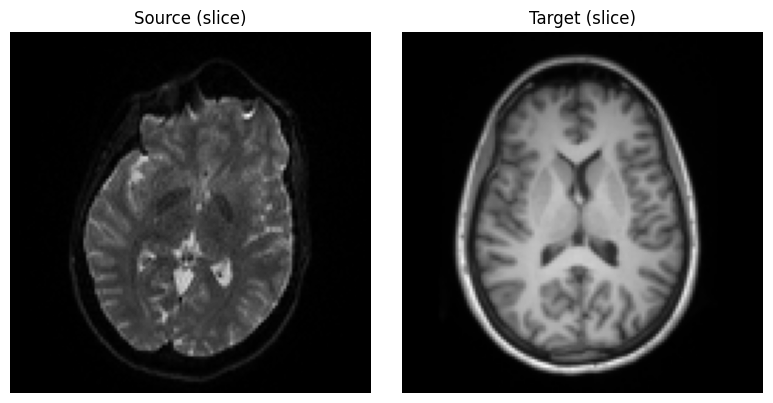

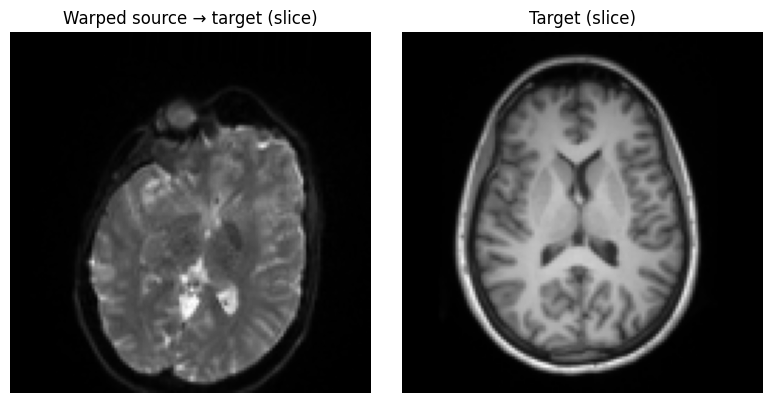

In [58]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --- Inputs you already have ---
# img_src: Tensor [1, D, H, W]
# img_tgt: Tensor [1, D, H, W]
# T_src_to_tgt: Tensor [4,4] (rigid transform from source->target)

device = img_src.device
dtype = torch.float32

# Ensure consistent device/dtype and add batch dim: [N,C,D,H,W]
img_src_b = img_src.to(device=device, dtype=dtype).unsqueeze(0)  # [1,1,D,H,W]
img_tgt_b = img_tgt.to(device=device, dtype=dtype).unsqueeze(0)  # [1,1,D,H,W]

N, C, D, H, W = img_src_b.shape

# For affine_grid, theta maps OUTPUT->INPUT.
theta = T_src_to_tgt[:-1, :].unsqueeze(0).to(dtype=dtype)# [1,3,4]
theta = get_inverse_transformation(T_src_to_tgt)[:,:-1,:].to(dtype=dtype)


# Build grid in target space pointing into source space
grid = F.affine_grid(theta, size=img_tgt_b.shape, align_corners=True)  # [1,D,H,W,3]

# Resample (warp) source -> target space
warped_src_to_tgt = F.grid_sample(
    img_src_b, grid, mode="bilinear", padding_mode="border", align_corners=True
)  # [1,1,D,H,W]

# --- Choose a slice index along the W axis (third spatial dim) ---
slice_k = W // 2

# Extract slices (D×H planes orthogonal to W)
src_slice     = img_src_b[0, 0, :, :, slice_k].cpu()
tgt_slice     = img_tgt_b[0, 0, :, :, slice_k].cpu()
warped_slice  = warped_src_to_tgt[0, 0, :, :, slice_k].cpu()

# -------- BEFORE WARP: plot source vs target --------
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(src_slice.T, cmap="gray", origin="lower")
axs[0].set_title("Source (slice)")
axs[0].axis("off")

axs[1].imshow(tgt_slice.T, cmap="gray", origin="lower")
axs[1].set_title("Target (slice)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

# -------- AFTER WARP: plot warped source vs target --------
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(warped_slice.T, cmap="gray", origin="lower")
axs[0].set_title("Warped source → target (slice)")
axs[0].axis("off")

axs[1].imshow(tgt_slice.T, cmap="gray", origin="lower")
axs[1].set_title("Target (slice)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


In [61]:
import torch
import torch.nn.functional as F

def _norm_from_vox(dhw, align_corners=True):
    D, H, W = dhw
    M = torch.eye(4, dtype=torch.float32)
    if align_corners:
        M[0,0], M[1,1], M[2,2] = 2.0/(W-1), 2.0/(H-1), 2.0/(D-1)
        M[0,3], M[1,3], M[2,3] = -1.0, -1.0, -1.0
    else:
        M[0,0], M[1,1], M[2,2] = 2.0/W, 2.0/H, 2.0/D
        M[0,3], M[1,3], M[2,3] = -1.0 + 1.0/W, -1.0 + 1.0/H, -1.0 + 1.0/D
    return M

def _vox_from_norm(dhw, align_corners=True):
    D, H, W = dhw
    M = torch.eye(4, dtype=torch.float32)
    if align_corners:
        M[0,0], M[1,1], M[2,2] = (W-1)/2.0, (H-1)/2.0, (D-1)/2.0
        M[0,3], M[1,3], M[2,3] = (W-1)/2.0, (H-1)/2.0, (D-1)/2.0
    else:
        M[0,0], M[1,1], M[2,2] = W/2.0, H/2.0, D/2.0
        M[0,3], M[1,3], M[2,3] = W/2.0 - 0.5, H/2.0 - 0.5, D/2.0 - 0.5
    return M

def build_theta_same_affine(
    M_ras: torch.Tensor,      # 4x4: src_RAS -> dst_RAS (from LTA)
    A_vox2ras: torch.Tensor,  # 4x4: vox -> RAS (same for src and dst)
    size_dst_dhw,             # (D,H,W) of destination tensor
    size_src_dhw,             # (D,H,W) of source tensor
    align_corners=True,
):
    """
    Returns theta (3x4) mapping output-normalized coords -> input-normalized coords,
    ready for torch.nn.functional.affine_grid.
    """
    device = M_ras.device
    A = A_vox2ras.to(device, dtype=torch.float32)
    # dest_vox -> src_vox (via RAS); invert M_ras because affine_grid wants out->in
    T_vox = torch.linalg.inv(A) @ torch.linalg.inv(M_ras.to(device, torch.float32)) @ A  # 4x4

    N_in  = _norm_from_vox(size_src_dhw, align_corners).to(device)
    V_out = _vox_from_norm(size_dst_dhw, align_corners).to(device)

    Theta_4x4 = N_in @ T_vox @ V_out         # out_norm -> in_norm
    return Theta_4x4[:3, :]                  # 3x4

def warp_src_to_dst_same_affine(
    src: torch.Tensor,       # [C,D,H,W]
    dst: torch.Tensor,       # [C,D,H,W] (used for output size only)
    M_ras: torch.Tensor,     # 4x4 src_RAS -> dst_RAS
    A_vox2ras: torch.Tensor, # 4x4 vox -> RAS (same for both)
    mode="bilinear", padding_mode="border", align_corners=True
) -> torch.Tensor:
    C, D_s, H_s, W_s = src.shape
    _, D_d, H_d, W_d = dst.shape
    src_b = src.unsqueeze(0)  # [1,C,D,H,W]
    theta = build_theta_same_affine(
        M_ras, A_vox2ras,
        size_dst_dhw=(D_d, H_d, W_d),
        size_src_dhw=(D_s, H_s, W_s),
        align_corners=align_corners
    ).unsqueeze(0)  # [1,3,4]
    grid = F.affine_grid(theta, size=(1, C, D_d, H_d, W_d), align_corners=align_corners)
    warped = F.grid_sample(src_b, grid, mode=mode, padding_mode=padding_mode, align_corners=align_corners)
    # --- Choose a slice index along the W axis (third spatial dim) ---
    slice_k = W // 2

    # Extract slices (D×H planes orthogonal to W)
    src_slice     = img_src_b[0, 0, :, :, slice_k].cpu()
    tgt_slice     = img_tgt_b[0, 0, :, :, slice_k].cpu()
    warped_slice  = warped[0, 0, :, :, slice_k].cpu()

    # -------- BEFORE WARP: plot source vs target --------
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(src_slice.T, cmap="gray", origin="lower")
    axs[0].set_title("Source (slice)")
    axs[0].axis("off")

    axs[1].imshow(tgt_slice.T, cmap="gray", origin="lower")
    axs[1].set_title("Target (slice)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    # -------- AFTER WARP: plot warped source vs target --------
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(warped_slice.T, cmap="gray", origin="lower")
    axs[0].set_title("Warped source → target (slice)")
    axs[0].axis("off")

    axs[1].imshow(tgt_slice.T, cmap="gray", origin="lower")
    axs[1].set_title("Target (slice)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    return warped.squeeze(0)  # [C,D_d,H_d,W_d]


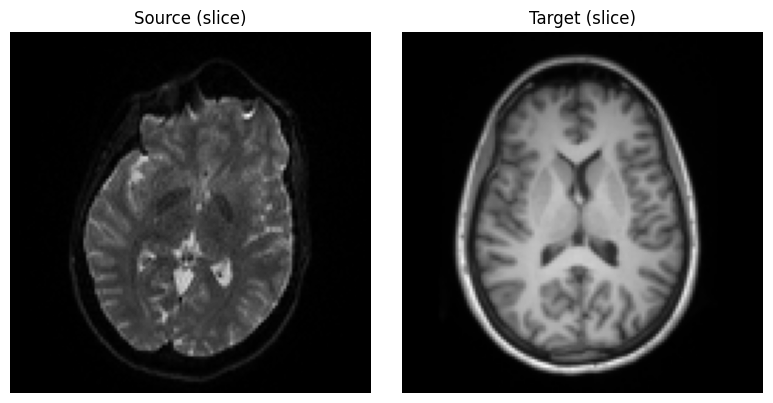

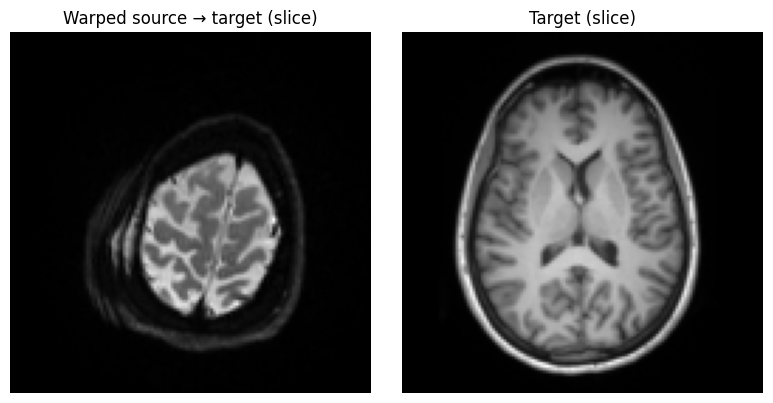

In [62]:
warped = warp_src_to_dst_same_affine(img_src, img_tgt, T_src_to_tgt, torch.eye(4), mode="bilinear", padding_mode="border", align_corners=True)
